---
# Part 1, Figures 3 and 4
Monte carlo oil spill volumes and oil capacity attribution

---

This graphic requires a shapefile `tanker_2018_allMonths.shp` that our licence agreement does not allow us to share.  Please contact [Spire Maritime](https://spire.com/maritime) to request a shapefile with AIS ship track data for 2018 and subset for tanker traffic.

This notebook also relies on functions in `monte_carlo_utils.py` and requires the inclusion of the directory with this script, namely `../scripts`, in PYTHONPATH, e.g.:
```
export PYTHONPATH=$PYTHONPATH:/path_to_this_repo/scripts
```
or uncommenting the following lines to import the scripts directory using sys: 
```
import sys
sys.path.insert(0, '../scripts')
```

Package requirements are included in ../environment.yaml.  Install in the upper-level directory using:
```
$ conda env create -f ./environment.yaml
```
                                                                               
To activate this environment, use 
```                  
$ conda activate midoss_env
```
 To deactivate an active environment, use
```
$ conda deactivate
```

Files are loaded from the dataset archive, with both the dataset archive and this code archive in the same folder, i.e.:

- \path\to\root\folder\
   - MuellerEtAl_MIDOSS_datasets
   - MuellerEtAl_MIDOSS_code [this repository]

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd  
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import cartopy.crs
import yaml
from matplotlib.offsetbox import AnchoredText

# adding path to midoss_utils, from analysis-rachael/scripts
sys.path.insert(0, '../scripts/')
from monte_carlo_utils import get_ECY_df, get_bin

## Define paths and files

In [2]:
# define relative paths
data_directory = Path('../../MuellerEtAl_MIDOSS_datasets')
graphics_directory = Path('../')

# oil attribution yaml file 
oil_attribution_file = (
    data_directory/'oil_attribution_yaml_files'/'oil_attribution.yaml'
)

# spreadsheet with oil capacity information for all ship types in study
oil_capacity_xls = data_directory/'spreadsheets'/'oil_capacity.xlsx'

# predefined naming conventions
sys.path.append('../graphics_utils/')
import graphics_setup as graphics

# graphics style
plt.style.use(r"../style_templates/MuellerEtAl_matplotlibrc.template")

# conversion factors
meters_to_feet = 3.28084
liters_to_gal = 0.264172 * 1e-6

# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)']


---
## Figure 4

---
Where is Figure 3...?  Patience, young padawan. (Scroll down)

## Plot oil capacities for cargo, atb, tanker
- Cargo: Line fit
- ATB: 
    - <= 50 m: Random cargo capacity by weights determined by number of AIS ship tracks
    - GT  50 m: Calculate capacity from linear fit
            C = oil_attrs["vessel_attributes"]["atb"]["cargo_fit_coefs"]
            fit_capacity = C[1] + C[0] * vessel_length
            # impose thresholds to yield output capacity
            cargo_capacity = _clamp(fit_capacity, atb_min_cargo, atb_max_cargo)
- Tanker: 
    - fuel_capacity = oil_attrs["vessel_attributes"]["tanker"][
            "fuel_capacity"
        ][bin_index]
    - cargo_capacity = oil_attrs["vessel_attributes"]["tanker"][
                "cargo_capacity"
            ][bin_index]
    - elif vessel_length > 150 and vessel_length <= 200:
            c_bin = oil_attrs["vessel_attributes"]["tanker"]["handy_capacity"]
            c_weight = oil_attrs["vessel_attributes"]["tanker"]["handy_weights"]
            cargo_capacity = random_generator.choice(
                c_bin,
                p = c_weight
            )
                
                

In [3]:
#~~~ Handymax traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
with open(oil_attribution_file,'r') as file:
    oil_attrs = yaml.load(file, Loader=yaml.FullLoader)

handy_capacity = np.array(oil_attrs["vessel_attributes"]["tanker"]["handy_capacity"])/1e6
handy_weights = np.array(oil_attrs["vessel_attributes"]["tanker"]["handy_weights"])

#~~~ cargo traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cargo_df = pd.read_excel(
    oil_capacity_xls, #oil_attrs['files']['oil_capacity'],
    sheet_name='cargo', 
    usecols='B,D,I,J'
)
length = cargo_df['vessel length (m)']
capacity = cargo_df['fuel capacity (liters)']/1e6

## Plot in CAD metrics

In [4]:
cargo_length = np.arange(150, 450, 20)

cargo_fit_coefs= np.polyfit(
    length, 
    np.log(capacity), 
    1
)
C = cargo_fit_coefs.tolist()
cargo_fit = (
    np.exp(C[1]) * 
    np.exp(C[0]*cargo_length)
)

# add ais-curated frequency data 
good_data = length>0

In [5]:
atb_capacity = np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_bin_centers"])/1e6
atb_weights = np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_probability"])

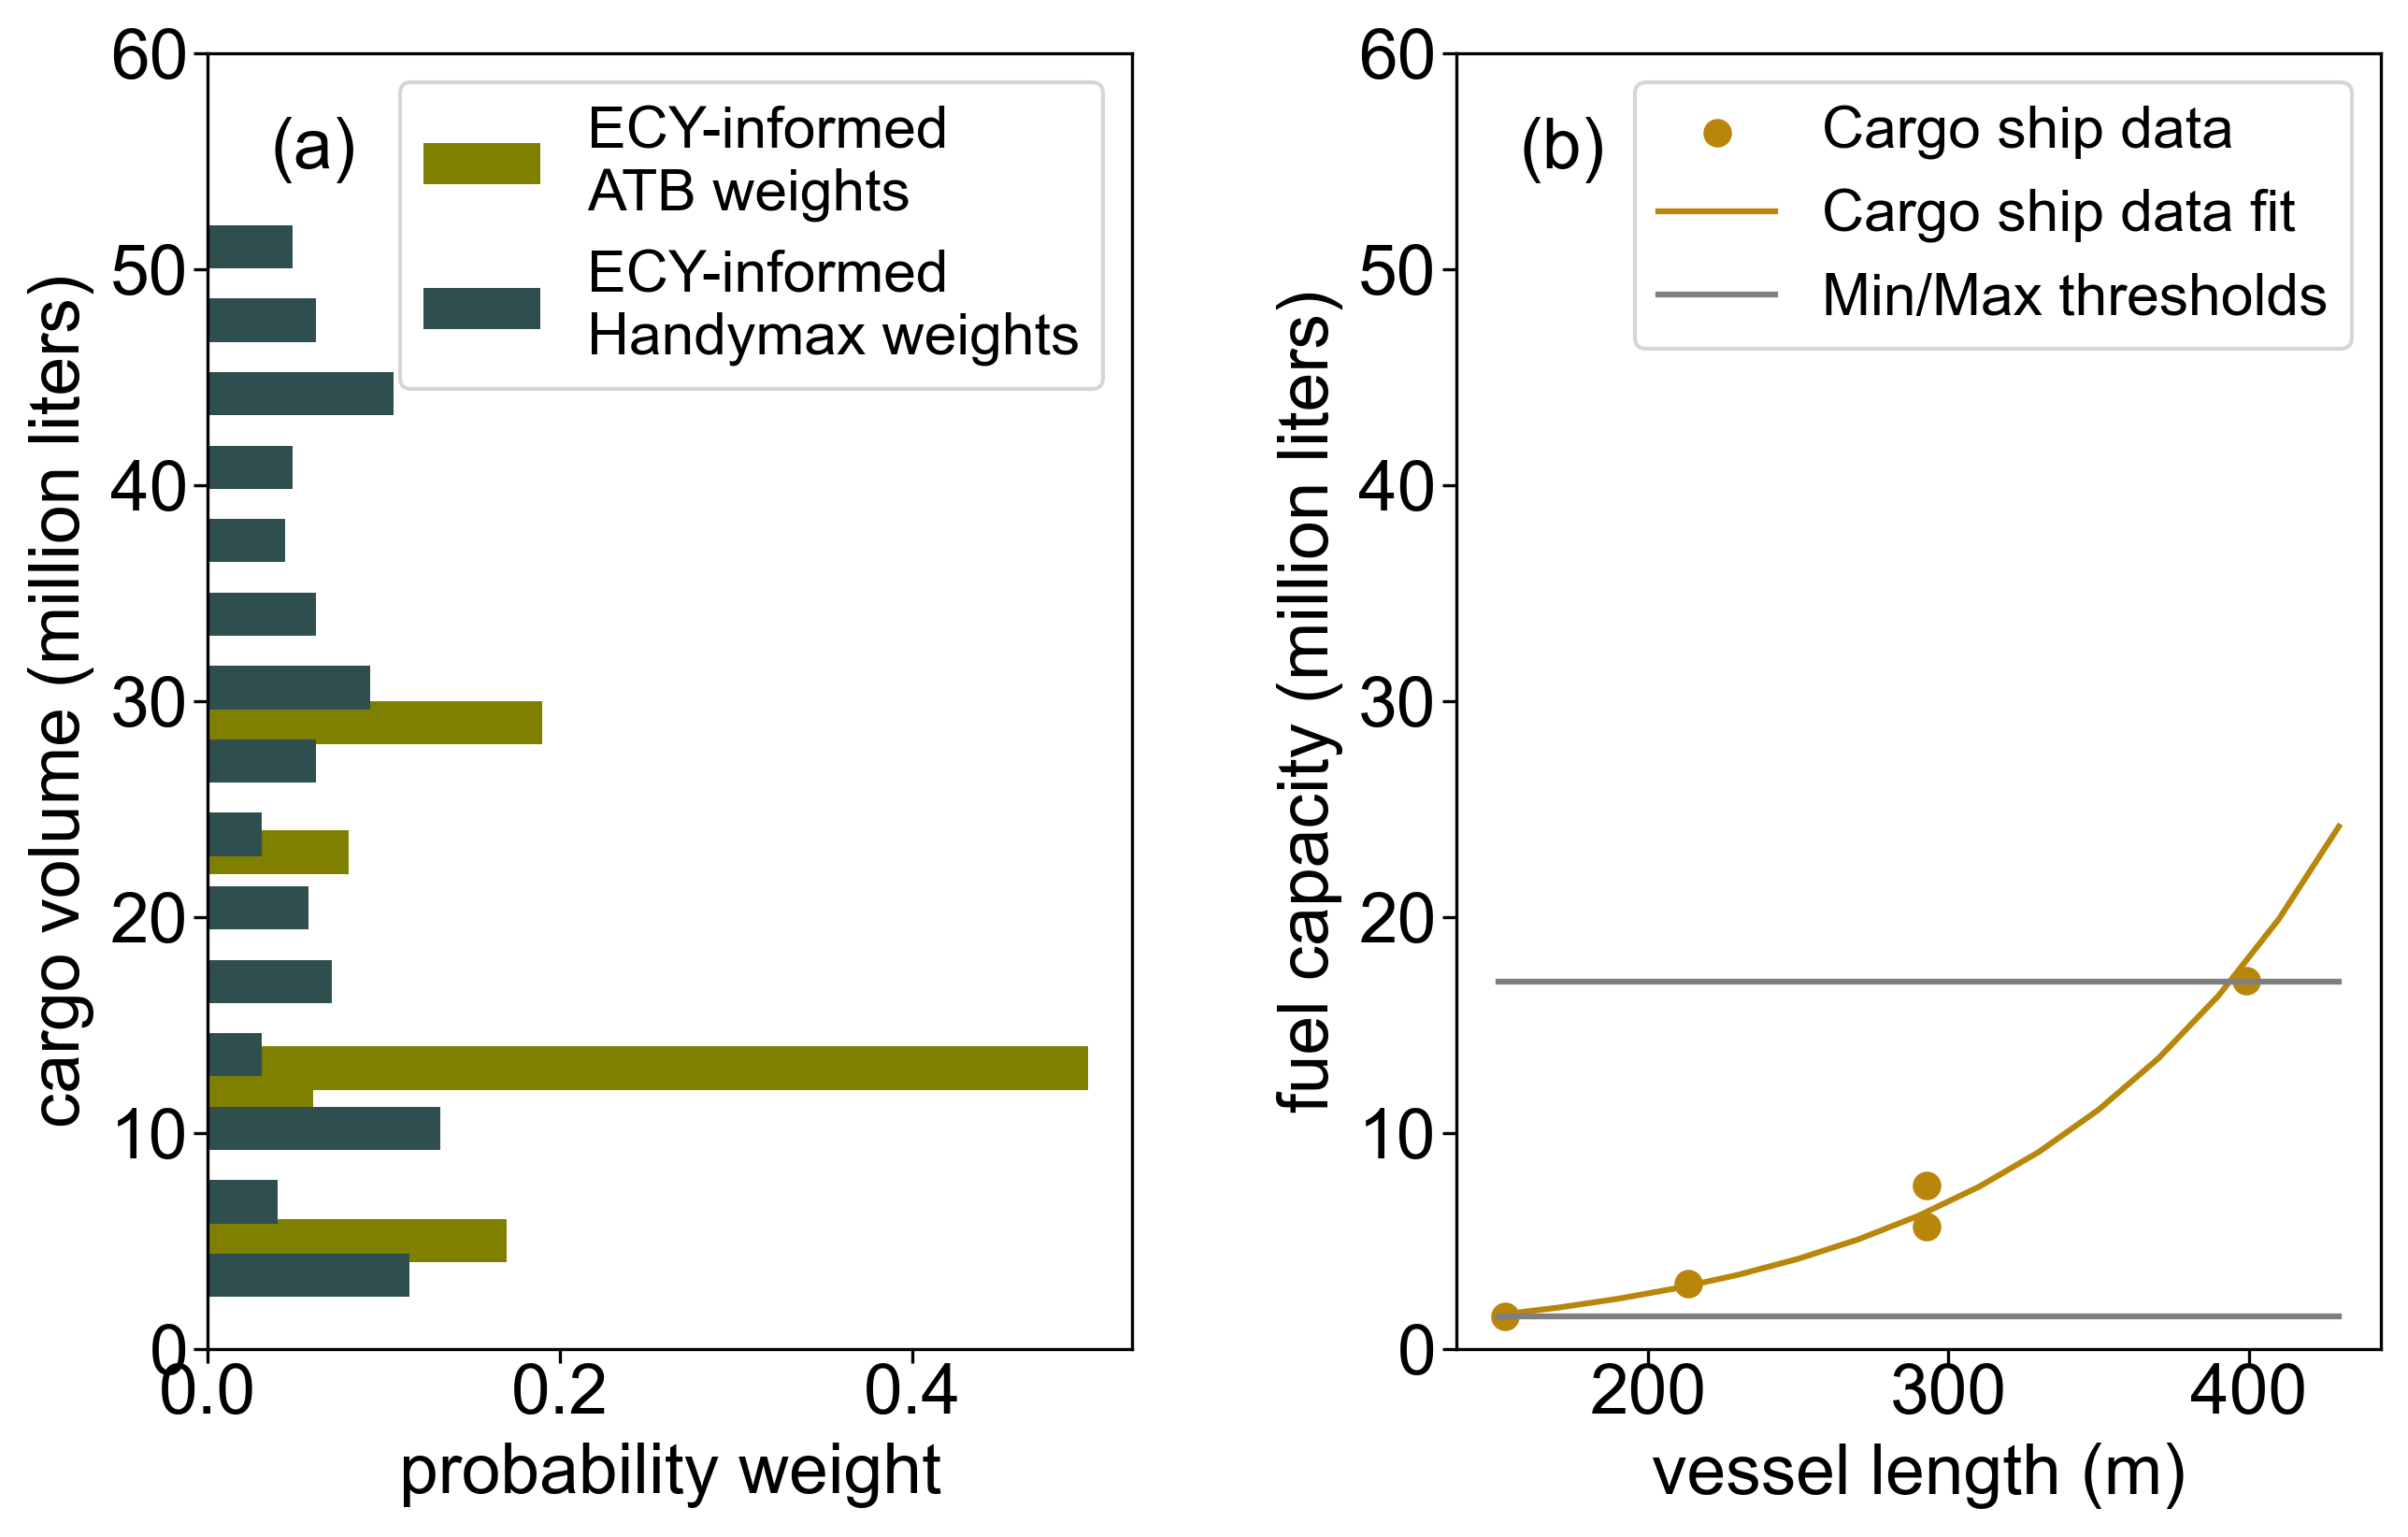

In [6]:
ylim = 60
fig = plt.figure() 
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(6)
# set width of each subplot as 8
fig.set_figwidth(10) 
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=.35,
                         hspace=1,width_ratios=[10,10])
                        #height_ratios=[4])
ax={}
ax[0] = fig.add_subplot(spec[0])
ax[1] = fig.add_subplot(spec[1])

# TANK traffic
ax[0].barh(atb_capacity,atb_weights, 
         .5*ylim/15, #scaled by ylim of US vs. CAD
         color=graphics.vesselcolors['atb'],
         label='ECY-informed \nATB weights')
ax[0].barh(handy_capacity,handy_weights, 
         .5*ylim/15, #scaled by ylim of US vs. CAD,
         color=graphics.vesselcolors['tanker'],
         label='ECY-informed \nHandymax weights')
ax[0].set(ylabel='cargo volume (million liters)')
ax[0].set_xlabel('probability weight')
ax[0].set_ylim(0,ylim)
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper right')

# Container ship capacities
ax[1].scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Cargo ship data ',
    color=graphics.vesselcolors['cargo']
)

ax[1].plot(
    cargo_length, 
    cargo_fit, 
    c=graphics.vesselcolors['cargo'], 
    label='Cargo ship data fit'#f'{np.exp(C[1]):.02e}e^{C[0]:.02f}$L$'
)

ax[1].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [oil_attrs['vessel_attributes']['cargo']['min_fuel']/1e6, 
     oil_attrs['vessel_attributes']['cargo']['min_fuel']/1e6],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax[1].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [oil_attrs['vessel_attributes']['cargo']['max_fuel']/1e6, 
     oil_attrs['vessel_attributes']['cargo']['max_fuel']/1e6],
    c='tab:grey'
)
# add subplot labels
#anchored_text = AnchoredText(axis_label[idx], loc=2, prop=dict(size=fs), frameon=False)
for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
ax[1].set_ylim(0,ylim)
ax[1].set_xlabel('vessel length (m)')
ax[1].set_ylabel('fuel capacity (million liters)')
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper right')

plt.savefig(graphics_directory/'Part1_Figure4_CapacityComparison_CAD_units.png')

Figure 4: Oil capacities used ATB and Handymax oil cargo tanks as well as container (cargo) ship fuel tanks. (a) Weights used to determine cargo volumes for ATBs (light green) and Handymax Tankers (dark green) based on Washington State Department of Ecology (ECY) transfer data [3]. These are the only two vessel types that had cargo volumes determined by a weighting function. All non-Handymax tanker capacities were fixed by tanker size class and other vessel types had oil capacities set by a length-based function based on line fits to data. (b) Line fit used to determine container ship fuel capacities based on vessel length. Dots represent the data points used to inform line fits. The grey lines show the minimum and maximum allowed capacities.

## Plot in US metrics

In [7]:
handy_capacity_liters = np.array(
    oil_attrs["vessel_attributes"]["tanker"]["handy_capacity"]
)
handy_capacity = liters_to_gal * handy_capacity_liters
handy_weights = np.array(
    oil_attrs["vessel_attributes"]["tanker"]["handy_weights"]
)

In [8]:
length = meters_to_feet*cargo_df['vessel length (m)']
capacity = liters_to_gal*cargo_df['fuel capacity (liters)']

cargo_length = np.arange(500, 1400, 50)

cargo_fit_coefs= np.polyfit(
    length, 
    np.log(capacity), 
    1
)
C = cargo_fit_coefs.tolist()
cargo_fit = (
    np.exp(C[1]) * 
    np.exp(C[0]*cargo_length)
)

# add ais-curated frequency data 
good_data = length>0

### Show plot of ATB cargo bins

In [9]:
atb_capacity = liters_to_gal*np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_bin_centers"])
atb_weights = np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_probability"])

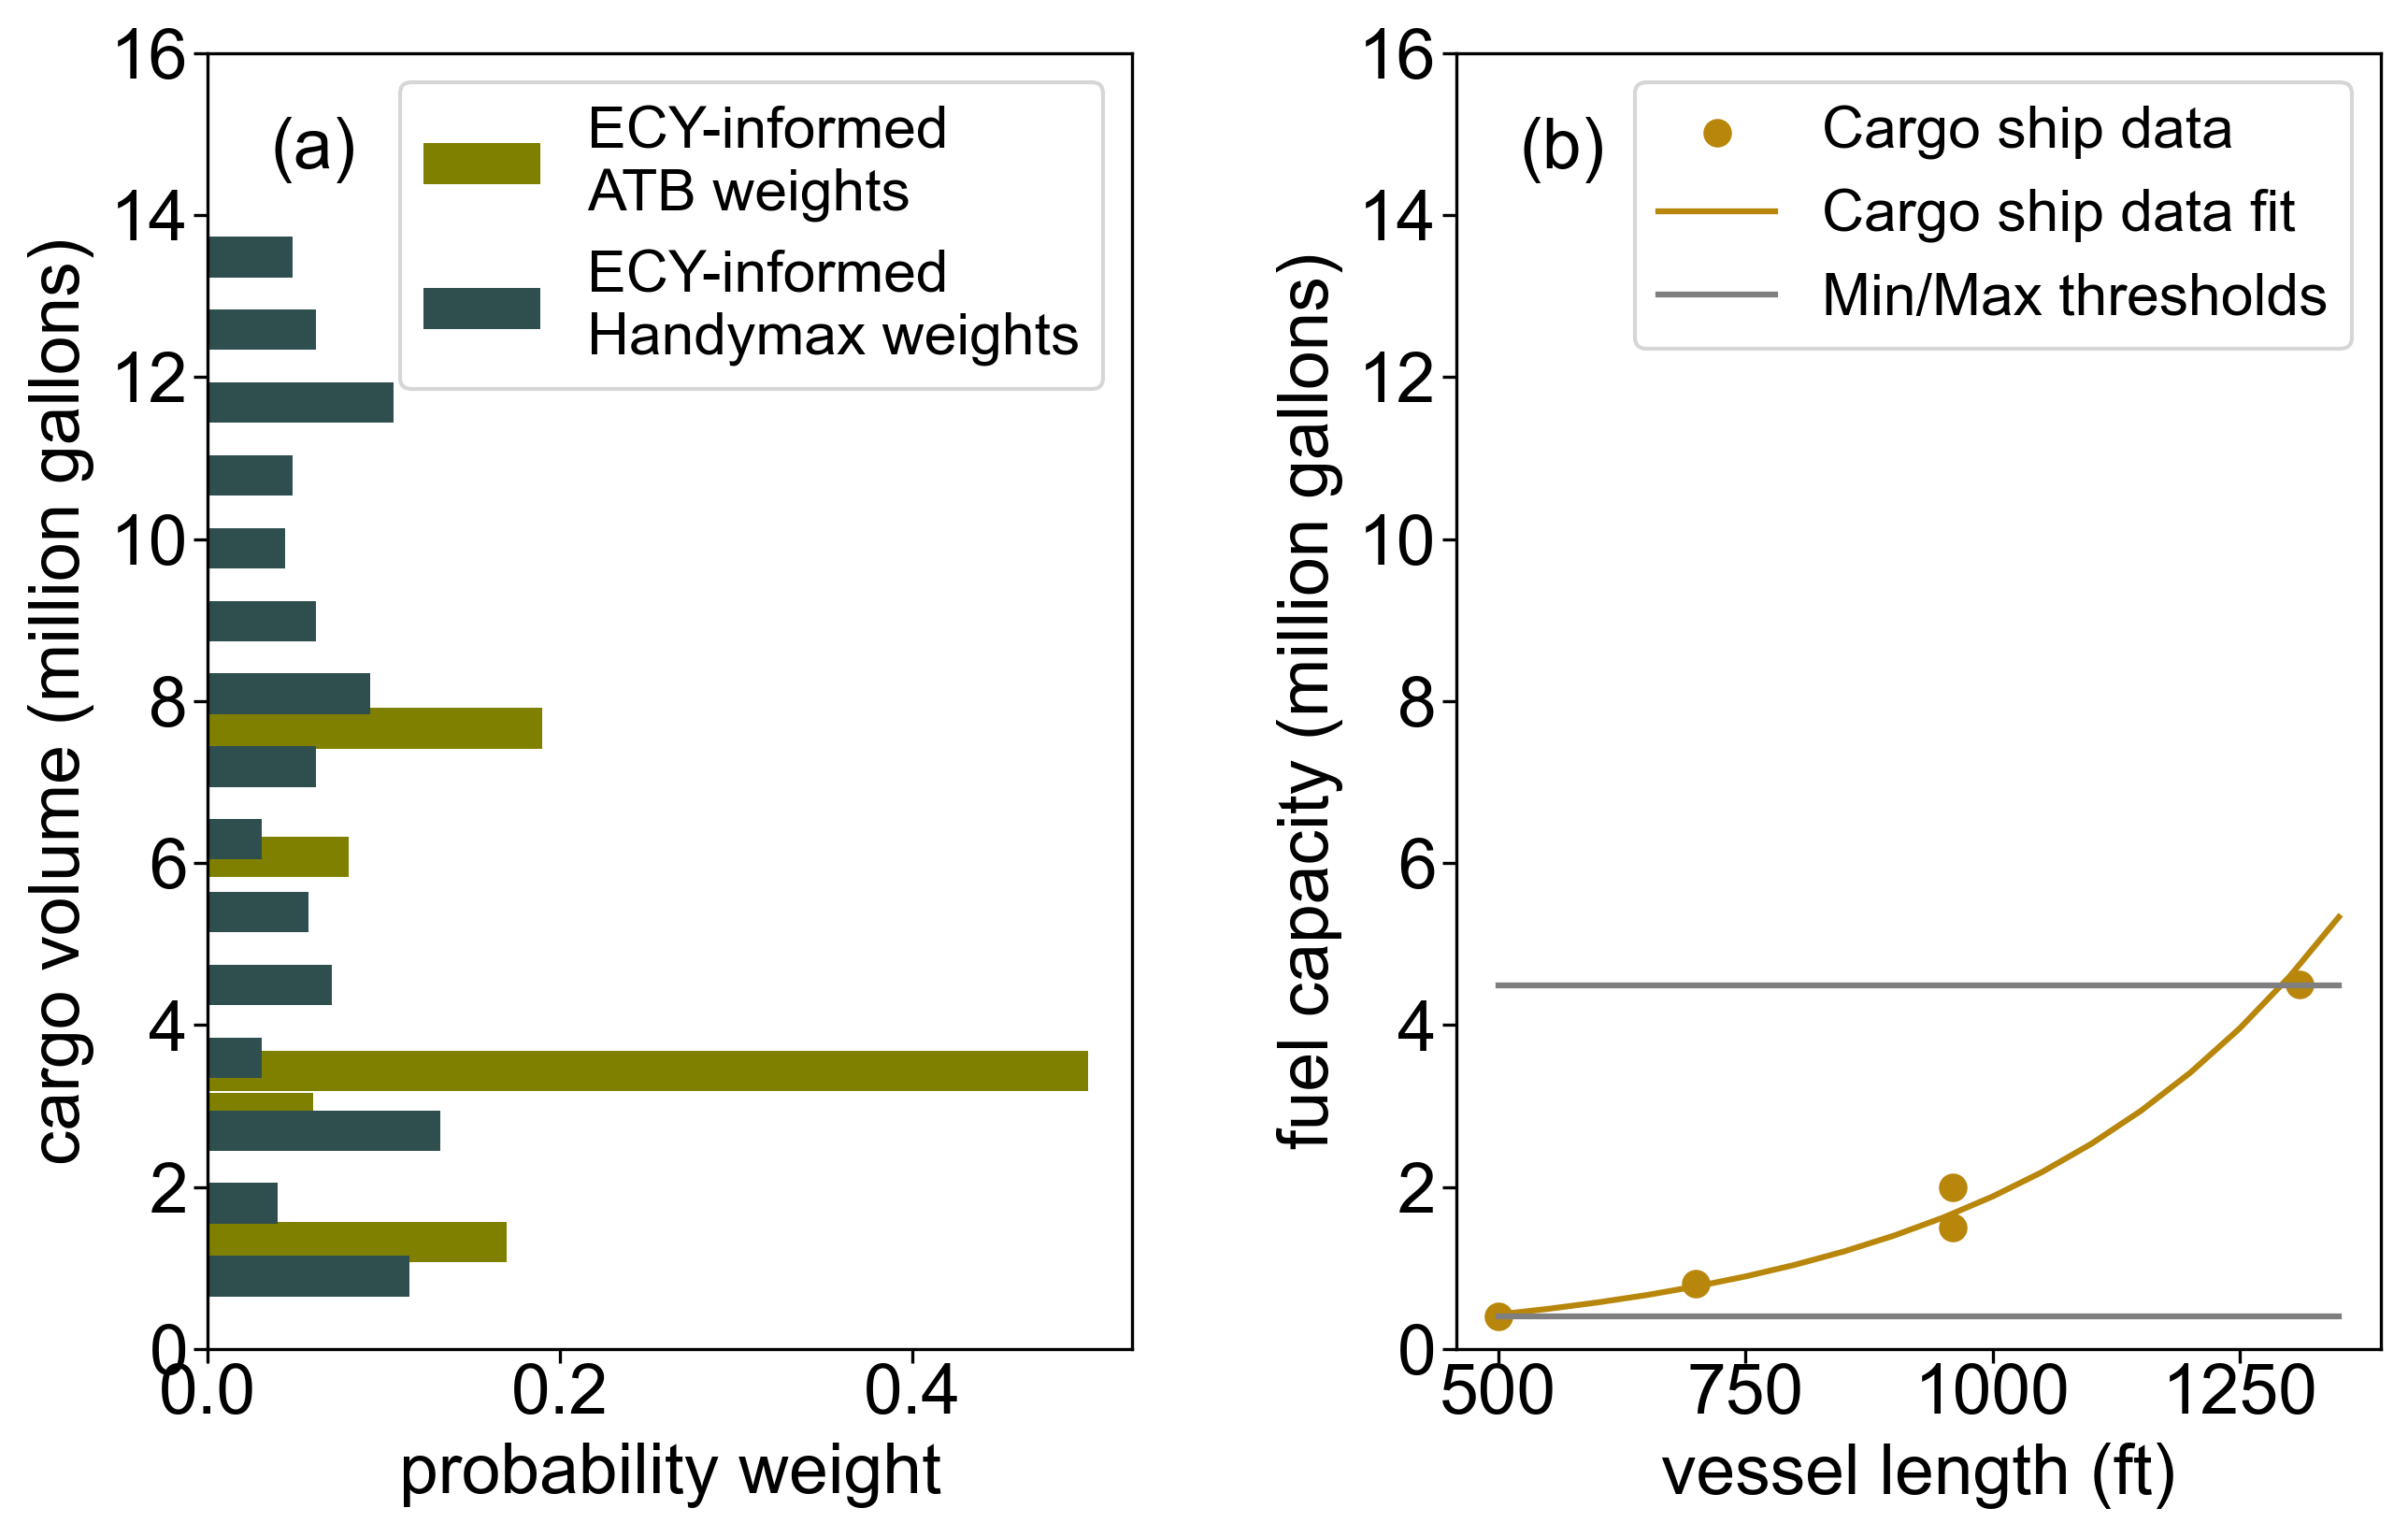

In [10]:
fig = plt.figure() 
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(6)
# set width of each subplot as 8
fig.set_figwidth(10) 
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=.35,
                         hspace=1,width_ratios=[10,10])
                        #height_ratios=[4])
ax={}
ax[0] = fig.add_subplot(spec[0])
ax[1] = fig.add_subplot(spec[1])

# TANK traffic
# ax2 = fig.add_subplot(122)
ax[0].barh(atb_capacity,atb_weights, 
         .5,
         color=graphics.vesselcolors['atb'],
         label='ECY-informed \nATB weights')
ax[0].barh(handy_capacity,handy_weights, 
         .5,
         color=graphics.vesselcolors['tanker'],
         label='ECY-informed \nHandymax weights')
ax[0].set(ylabel='cargo volume (million gallons)')
ax[0].set_xlabel('probability weight')
ax[0].set_ylim(0,16)
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper right')

# Container ship capacities
ax[1].scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Cargo ship data ',
    color=graphics.vesselcolors['cargo']
)

ax[1].plot(
    cargo_length, 
    cargo_fit, 
    c=graphics.vesselcolors['cargo'], 
    label='Cargo ship data fit'#f'{np.exp(C[1]):.02e}e^{C[0]:.02f}$L$'
)

ax[1].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [liters_to_gal*oil_attrs['vessel_attributes']['cargo']['min_fuel'], 
     liters_to_gal*oil_attrs['vessel_attributes']['cargo']['min_fuel']],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax[1].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [liters_to_gal*oil_attrs['vessel_attributes']['cargo']['max_fuel'], 
     liters_to_gal*oil_attrs['vessel_attributes']['cargo']['max_fuel']],
    c='tab:grey'
)
#anchored_text = AnchoredText(axis_label[idx], loc=2, prop=dict(size=fs), frameon=False)
for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
ax[1].set_ylim(0,16)
ax[1].set_xlabel('vessel length (ft)')
ax[1].set_ylabel('fuel capacity (million gallons)')
#ax1.set_title('Container Ship')
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper right')

plt.savefig(graphics_directory/'Part1_Figure4_CapacityComparison_US_units.png')


Figure 4: Oil capacities used ATB and Handymax oil cargo tanks as well as container (cargo) ship fuel tanks. (a) Weights used to determine cargo volumes for ATBs (light green) and Handymax
Tankers (dark green) based on Washington State Department of Ecology (ECY) transfer data [3]. These are the only two vessel types that had cargo volumes determined by a weighting function. All non-Handymax tanker capacities were fixed by tanker size class and other vessel types had oil capacities set by a length-based function based on line fits to data. (b) Line fit used to determine container ship fuel capacities based on vessel length. Dots represent the data points used to inform line fits. The grey lines show the minimum and maximum allowed capacities.

---
## Figure 3

---

# Tanker track, capacity, and transfer behaviors
This graphic requires a shapefile `tanker_2018_allMonths.shp` that our licence agreement does not allow us to share.  Please contact [Spire Maritime](https://spire.com/maritime) to request a shapefile with AIS ship track data for 2018 and subset for tanker traffic.  

In [11]:
%%time
allTracks_tanker = gpd.read_file(
    "../../../../Data/MIDOSS/tanker_shapefile/tanker_2018_allMonths.shp"
)
allTracks_tanker = allTracks_tanker.reset_index(drop=True)

bins = []
bins.append((0, 60))
bins.append((61, 150))
bins.append((151, 200))
bins.append((201, 250))
bins.append((251, 300))
binned_data = np.zeros(len(bins))
size_classes = [
    "Smallest Tanker (< 60 m)",
    "Small Tanker (61 - 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "Suezmax (251-300 m)" 
]
binned_mmsi = pd.DataFrame(columns = size_classes)
for idx,value in enumerate(allTracks_tanker["LENGTH"]):
    if value > 0:
        bin_index = get_bin(value, bins)  
        binned_data[bin_index] += 1  

CPU times: user 3.89 s, sys: 244 ms, total: 4.13 s
Wall time: 4.21 s


Total number of MMSI by size class (in QAQC_Tanker....)
-  **1**  Smallest Tanker (< 60 m) vessels
-  **19**  Small Tanker (61 - 150 m) vessels
-  **140**  Handymax (151-200 m) vessels
-  **69**  Aframax (201-250 m) vessels
-  **29**  Suezmax (251-300 m) vessels

In [12]:
## From ECY_Tanker_transfers.ipynb
# Smallest: 35 one-way, 2 two-way transfers
# Small: 48 one-way, 0 two-way transfers
# Handymax: 134 one-way, 93 two-way transfers
# Aframax: 8 one-way, 2 two-way transfers
# Suezmax: 39 one-way, 3 two-way transfers

one_way=[35/37,48/48,134/(134+93),8/10,39/42]
two_way=[2/37,0/48,93/(134+93),2/10,3/42]
## From monte_carlo_QAQC/QAQC_Tanker_AISlengths_DOEcapacities.ipynb
percent_traffic = [1,.5455,.5815,.1799,.5080]

## CAD units

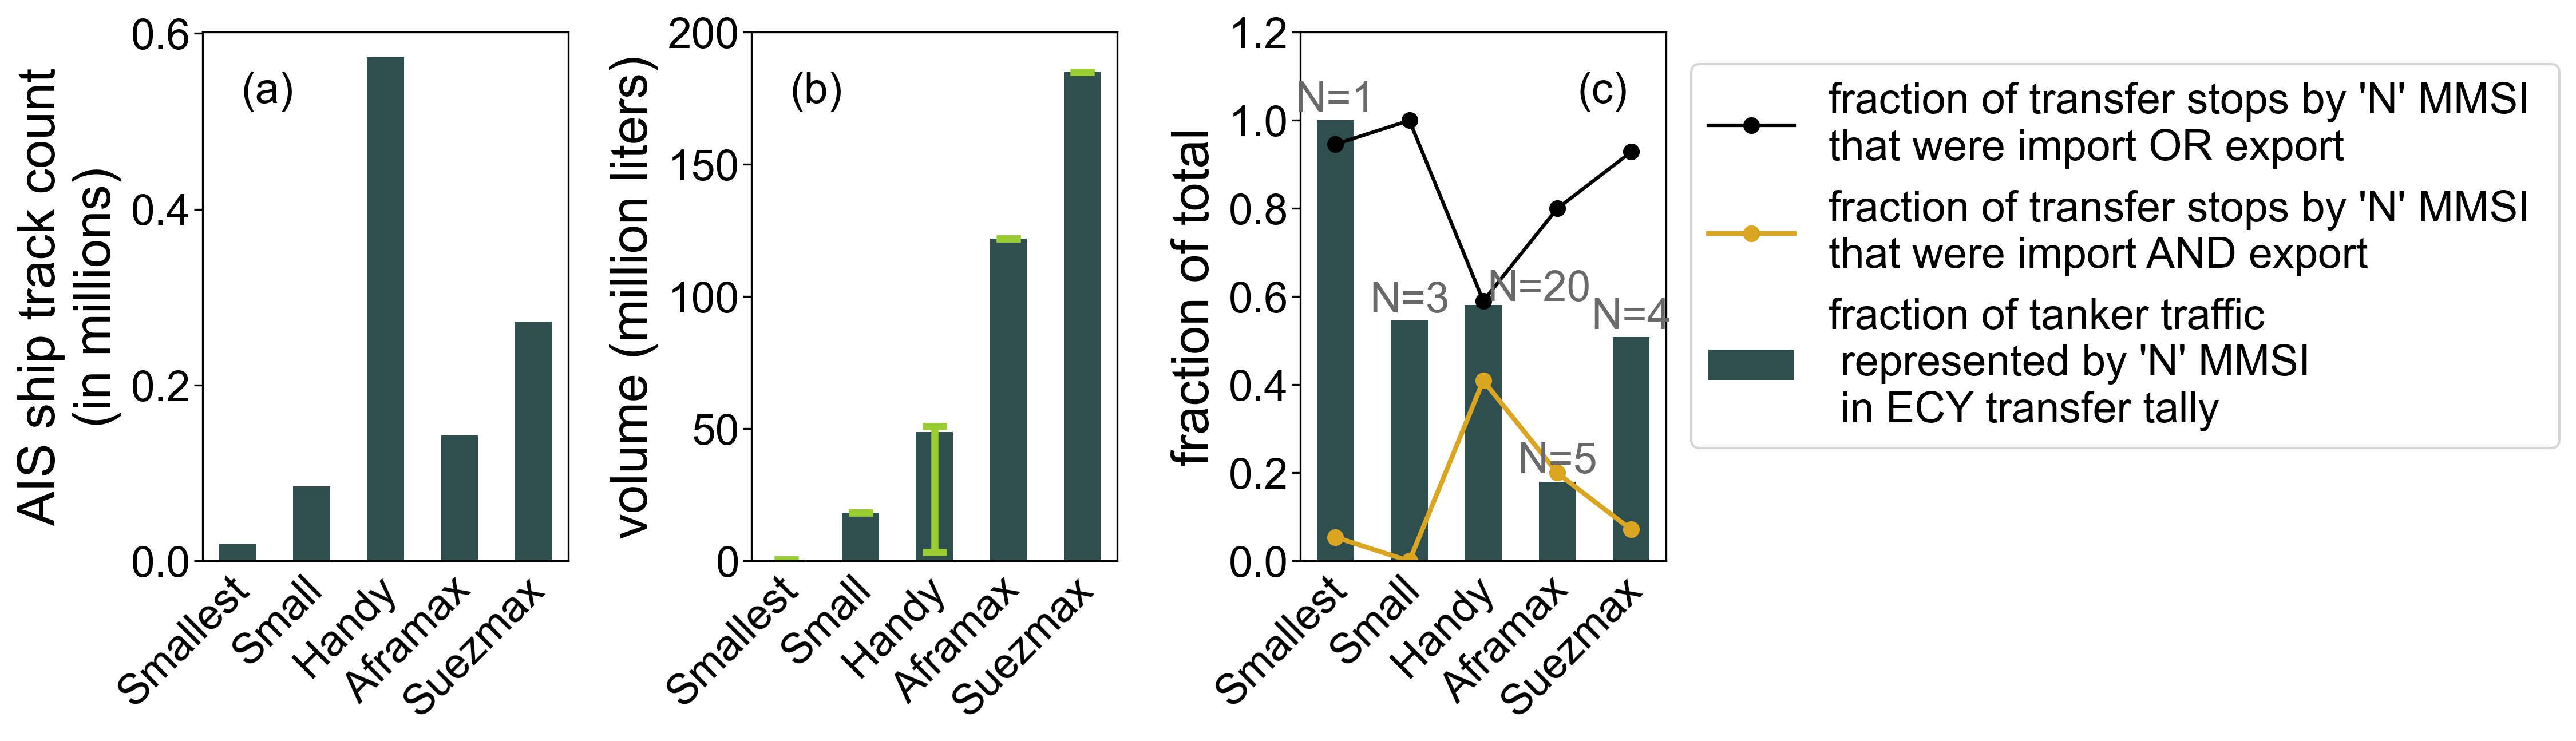

In [13]:
handy_min = np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).min()/1e6
handy_max = np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).max()/1e6
size_classes_label=['Smallest','Small','Handy','Aframax','Suezmax']
fig, ax = plt.subplots(nrows=1, ncols=3, 
                       gridspec_kw={
                           'width_ratios': [15, 15,15],
                           'height_ratios': [1],
                       'wspace': 0.5,
                       'hspace': 0.8})   
fig.set_figheight(4)
fig.set_figwidth(11)
ind = np.arange(len(binned_data))  # the x locations for the groups
ax[0].bar(ind, binned_data/1e6, 0.5, color=graphics.vesselcolors["tanker"])
ax[0].set_xticks(ind+1/4)
#ax[0].set_yticks([0, 0.2, 0.4, 0.6])
#ax[0].set_yticklabels(['0.0', '0.2', '0.4', '0.6'])
ax[0].ticklabel_format(style='plain')
ax[0].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
#ax[0].set_ylim(0, .7)
for ix in [0,1,2]:
    ax[ix].tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
ax[0].set_ylabel('AIS ship track count\n(in millions)',fontsize='large')
#ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

## Cargo capacities for different size classes
tanker_capacities = [oil_attrs['vessel_attributes']['tanker']['cargo_capacity'][ind]/1e6 for ind in np.arange(0,5)]
ax[1].bar(ind, tanker_capacities, 0.5, 
          yerr=[[0,0,tanker_capacities[2]-handy_min,0,0],[0,0,handy_max-tanker_capacities[2],0,0]],
          error_kw=dict(ecolor='yellowgreen', lw=3, capsize=5, capthick=3),
          color=graphics.vesselcolors["tanker"])
ax[1].set_ylim(0,200)
ax[1].set_xticks(ind+1/4)
ax[1].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
ax[1].set_ylabel('volume (million liters)',fontsize='large')
# transfers
ax[2].plot(ind,one_way,'-o',
          color="black",
          label="fraction of transfer stops by 'N' MMSI \nthat were import OR export")
ax[2].plot(ind,two_way,'-o',
        linewidth=2,
          color="goldenrod",
          label="fraction of transfer stops by 'N' MMSI \nthat were import AND export")
ax[2].bar(ind,percent_traffic,.5,
          color=graphics.vesselcolors["tanker"],
          label="fraction of tanker traffic \n represented by 'N' MMSI\n in ECY transfer tally")
ax[2].set_ylabel('fraction of total',fontsize='large')
ax[2].set_ylim(0,1.2)
ax[2].set_xticks(ind+1/4)
ax[2].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right',fontsize='medium')
# Number of MMSI used in DOE transfer tally
N=[1,3,20,5,4]
for i, v in enumerate(percent_traffic):
    if i==2:
        ax[2].text(i+.75, v-.01, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
    else:
        ax[2].text(i, v, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
ax[2].legend(bbox_to_anchor=(1.01, 0.98), loc='upper left',fontsize='medium')
# add subplot labels
#anchored_text = AnchoredText(axis_label[idx], loc=2, prop=dict(size=fs), frameon=False)
for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
anchored_text = AnchoredText(subplot_labels[2], loc=1, frameon=False)
ax[2].add_artist(anchored_text)
plt.savefig(graphics_directory/'Part1_Figure3_Tanker_TracksCapacities_CAD_units.png')

Figure 3: oil tanker transport characteristics. (a) 2018 AIS ship track count by tanker vessel size class, (b) cargo volume capacity for each size class with light green bar or range showing the volume(s) used in this study, and (c) the fraction of AIS ship tracks accounted for by the N number of MMSI used to identify one-way transfers (black line) and two-way transfers (yellow
line) reported in Washington State Department of Ecology (ECY) oil transfer data.

## US units

In [14]:
meters_to_feet = 3.28084
liters_to_gal = 0.264172 * 1e-6

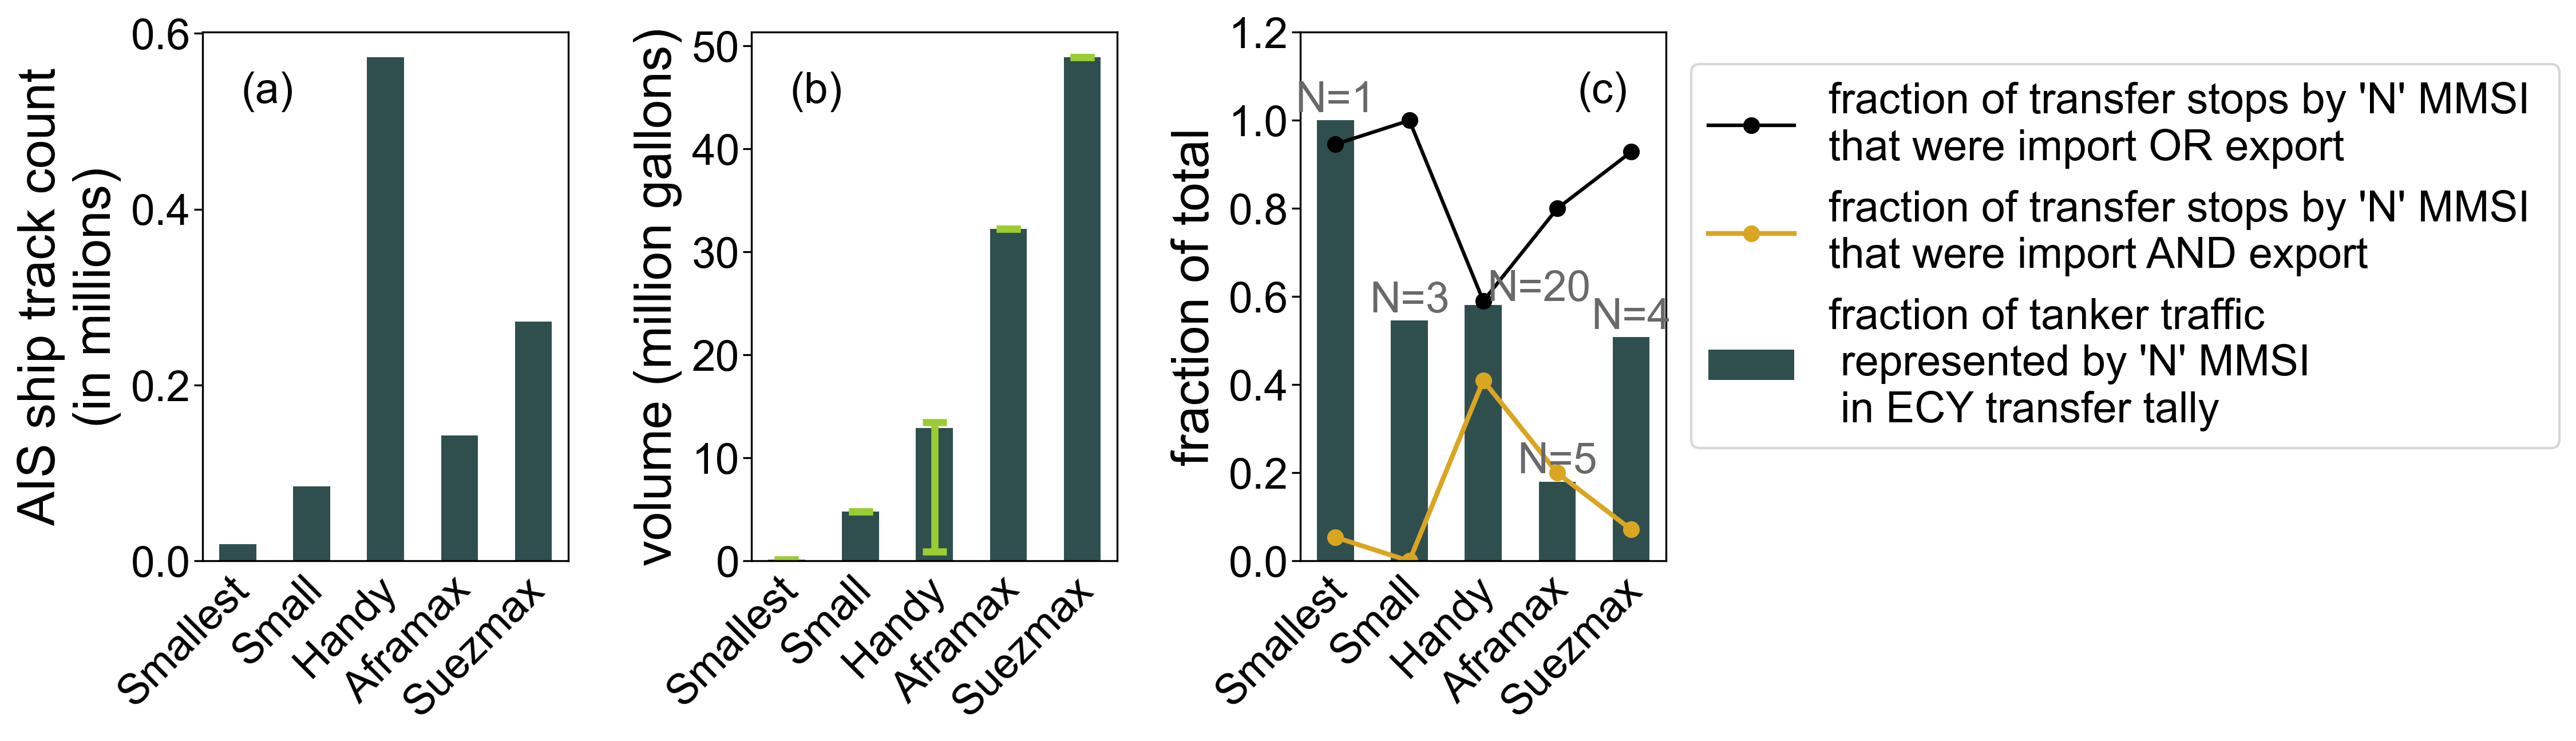

In [15]:
# min/max of oil capacity for handymax
handy_min = liters_to_gal*np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).min()
handy_max = liters_to_gal*np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).max()
size_classes_label=['Smallest','Small','Handy','Aframax','Suezmax']
fig, ax = plt.subplots(nrows=1, ncols=3, 
                       #figsize=(15, 5),
                       gridspec_kw={
                           'width_ratios': [15, 15,15],
                           'height_ratios': [1],
                       'wspace': 0.5,
                       'hspace': 0.8})   
fig.set_figheight(4)
# set width of each subplot as 8
fig.set_figwidth(11)

#width = 0.75 # the width of the bars 
ind = np.arange(len(binned_data))  # the x locations for the groups
ax[0].bar(ind, binned_data/1e6, 0.5, color=graphics.vesselcolors["tanker"])
ax[0].set_xticks(ind+1/4)
#ax[0].set_yticks([0, 0.2, 0.4, 0.6])
#ax[0].set_yticklabels(['0.0', '0.2', '0.4', '0.6'])
ax[0].ticklabel_format(style='plain')
ax[0].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
#ax[0].set_ylim(0, .7)
for ix in [0,1,2]:
    ax[ix].tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
ax[0].set_ylabel('AIS ship track count\n(in millions)',fontsize='large')
#ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

## Cargo capacities for different size classes
tanker_capacities = [liters_to_gal*oil_attrs['vessel_attributes']['tanker']['cargo_capacity'][ind] for ind in np.arange(0,5)]
ax[1].bar(ind, tanker_capacities, 0.5, 
          yerr=[[0,0,tanker_capacities[2]-handy_min,0,0],[0,0,handy_max-tanker_capacities[2],0,0]],
          error_kw=dict(ecolor='yellowgreen', lw=3, capsize=5, capthick=3),
          color=graphics.vesselcolors["tanker"])
#ax[1].set_ylim(0,2e8)
ax[1].set_xticks(ind+1/4)
ax[1].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
ax[1].set_ylabel('volume (million gallons)',fontsize='large')
# transfers
ax[2].plot(ind,one_way,'-o',
          color="black",
          label="fraction of transfer stops by 'N' MMSI \nthat were import OR export")
ax[2].plot(ind,two_way,'-o',
        linewidth=2,
          color="goldenrod",
          label="fraction of transfer stops by 'N' MMSI \nthat were import AND export")
ax[2].bar(ind,percent_traffic,.5,
          color=graphics.vesselcolors["tanker"],
          label="fraction of tanker traffic \n represented by 'N' MMSI\n in ECY transfer tally")
ax[2].set_ylabel('fraction of total',fontsize='large')
ax[2].set_ylim(0,1.2)
ax[2].set_xticks(ind+1/4)
ax[2].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right',fontsize='medium')
# Number of MMSI used in DOE transfer tally
N=[1,3,20,5,4]
for i, v in enumerate(percent_traffic):
    if i==2:
        ax[2].text(i+.75, v-.01, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
    else:
        ax[2].text(i, v, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
ax[2].legend(bbox_to_anchor=(1.01, 0.98), loc='upper left',fontsize='medium')
# add subplot labels
#anchored_text = AnchoredText(axis_label[idx], loc=2, prop=dict(size=fs), frameon=False)
for idx in [0,1]:
    anchored_text = AnchoredText(subplot_labels[idx], loc=2, frameon=False)
    ax[idx].add_artist(anchored_text)
anchored_text = AnchoredText(subplot_labels[2], loc=1, frameon=False)
ax[2].add_artist(anchored_text)
plt.savefig(graphics_directory/'Part1_Figure3_Tanker_TracksCapacities_US_units.png')

Figure 3: oil tanker transport characteristics. (a) 2018 AIS ship track count by tanker vessel size class, (b) cargo volume capacity for each size class with light green bar or range showing the volume(s) used in this study, and (c) the fraction of AIS ship tracks accounted for by the N number of MMSI used to identify one-way transfers (black line) and two-way transfers (yellow
line) reported in Washington State Department of Ecology (ECY) oil transfer data.